In [1]:
import numpy as np
import deepdish as dd
import pandas as pd
from brian2.only import second
import matplotlib.pyplot as plt
import seaborn as sns

from sweep import get_script
from spike_utils import compute_delta_p_array
from grid_criticality import analysis_path, path_pr
from grid_postprocessing import p_list, r_list

import plot_utils as pu

In [2]:
from scipy.optimize import curve_fit
def power_law(x,a,b):
    y=a*pow(x,b)
    return y

In [3]:
delta_p = pd.read_csv(f'{analysis_path}/criticality_data.csv', index_col=0)
ioi = 976
poi = delta_p.loc[ioi, 'p_inh']
roi = delta_p.loc[ioi, 'r_inh']
runseed = delta_p.loc[ioi, 'runseed']
net = delta_p.loc[ioi, 'net']

In [4]:
p_highlights = ('01', '05', 1)
r_highlights = ('05', 2, 4)

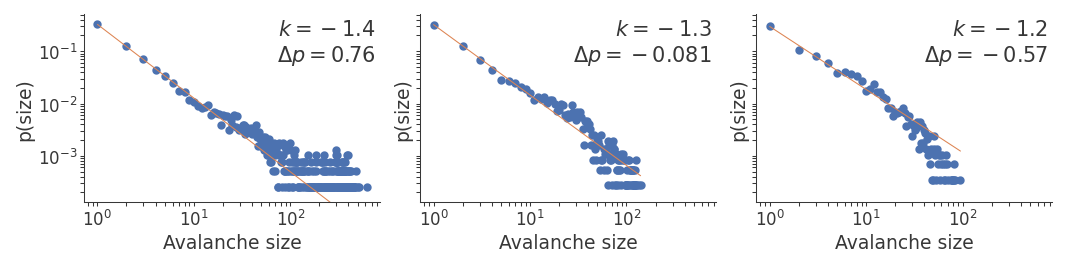

In [5]:
def plot_detail(path, tprobe, ax):
    spike_stats = dd.io.load(f'{path}/spike_stats_12ms.h5')
    t_spike, lists_delta_p_array = compute_delta_p_array(spike_stats)

    i = np.where(t_spike == tprobe)[0][0]

    avalanche_size = spike_stats['avalanche'][net][i]
    avalanche_size = np.array(avalanche_size, dtype=int)
    freq=np.zeros(avalanche_size.max())
    for s in avalanche_size:
        freq[s-1] +=1
    size=np.arange(1,avalanche_size.max()+1)
    freq_nonzero=freq[freq!=0]
    size=size[freq!=0]
    prob=freq_nonzero/freq_nonzero.sum()
    popt,pcov = curve_fit(power_law, size, prob)
    ax.loglog(size, prob, '.')
    ax.loglog(size, power_law(size, popt[0],popt[1]))

    dp = np.mean(np.log(prob)-np.log(power_law(size, popt[0], popt[1])))
    ax.annotate(f'$k={popt[1]:.2g}$\n$\Delta p={dp:.2g}$', xy=(1,1), xycoords='axes fraction', xytext=(-5,-5), textcoords='offset pixels', ha='right', va='top')

    ax.set_ylabel('p(size)')
    ax.set_xlabel('Avalanche size')
    sns.despine(ax=ax)

    return min(prob)

fig, axs = plt.subplots(1,3, figsize=pu.fullwidth(1.5), layout='constrained', sharex=True, sharey=True, dpi=150, facecolor='w')
min_p = []
for p, r, ax in zip(p_highlights, r_highlights, axs):
    script, path = get_script(f'lif_alpha_beta_1_different_net_seed_0_pinh_{p}_rinh_{r}_runseed_{runseed}')
    min_p.append(plot_detail(path, 15, ax))
ax.set_ylim(bottom=min(min_p)/2);

In [6]:
def get_netspikes(script, path, iteration, tmin, tmax):
    N, N_nets = script.params['N'], script.params['N_nets']
    inh_ratio = script.params.get('inhibitory_ratio', 0.2)
    N_exc = int(N*(1-inh_ratio))
    N_inh = N - N_exc
    elo, ilo = net*N_exc, N_nets*N_exc + net*N_inh
    ehi, ihi = elo + N_exc, ilo + N_inh
    
    spikes = dd.io.load(f'{path}/spikes_{iteration}.h5')

    # First filter: Net
    emask = (spikes['i'] >= elo) & (spikes['i'] < ehi)
    imask = (spikes['i'] >= ilo) & (spikes['i'] < ihi)
    mask = emask | imask

    spike_i = spikes['i'][mask]
    spike_t = spikes['t'][mask]

    # Adjust indices
    spike_i[spike_i < ehi] -= elo
    spike_i[spike_i >= ilo] -= ilo - N_exc

    # Second filter: Time
    tmask = (spike_t >= tmin) & (spike_t < tmax)
    
    return spike_i[tmask], spike_t[tmask] - tmin

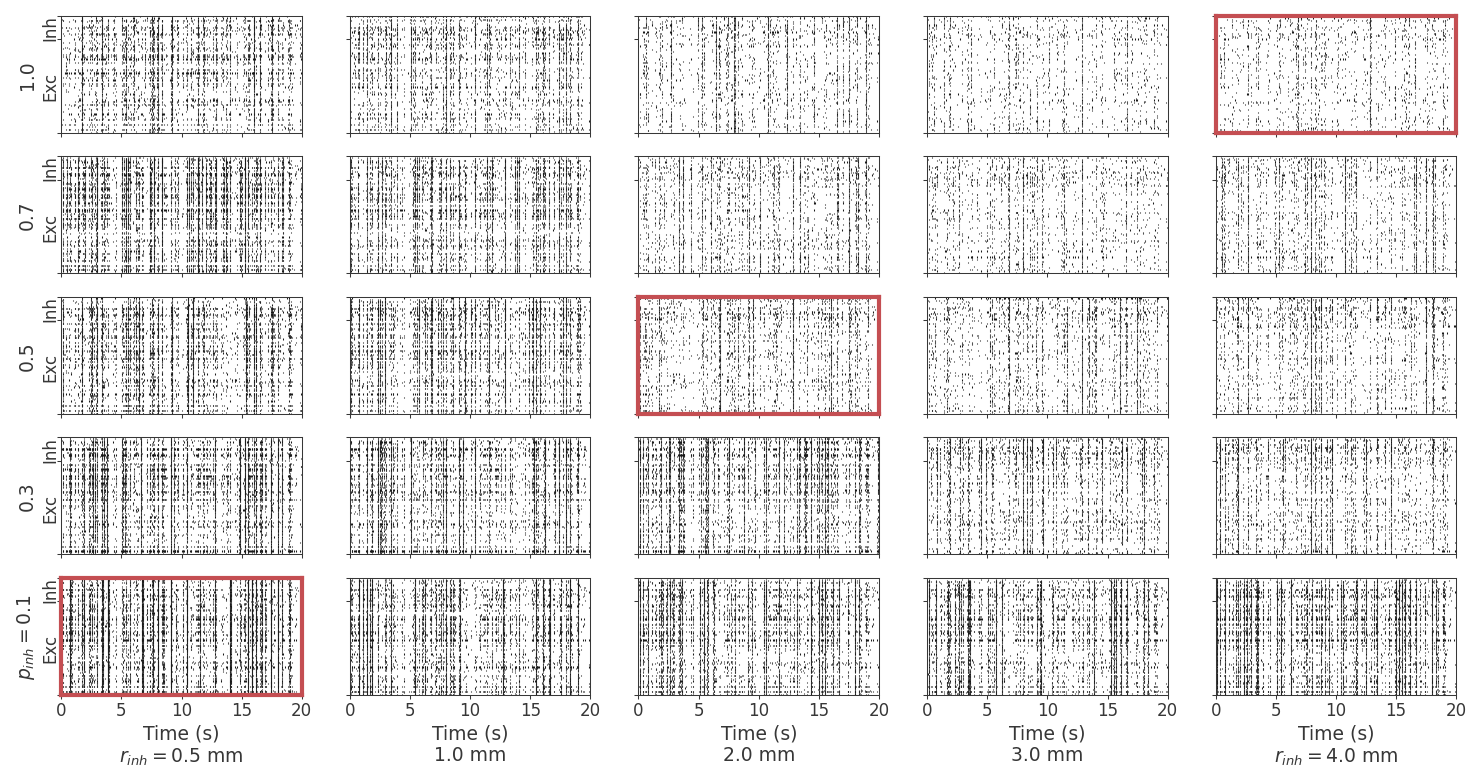

In [7]:
def plot_rasters(axs):
    for axr, p in zip(axs[::-1], ['01', '03', '05', '07', 1]):
        for ax, r in zip(axr, ['05', 1, 2, 3, 4]):
            script, path = get_script(f'lif_alpha_beta_1_different_net_seed_0_pinh_{p}_rinh_{r}_runseed_{runseed}')
            p_inh=script.params['p_connection']['IE']
            r_inh=script.params['radius_inh']

            spike_i, spike_t = get_netspikes(script, path, script.iterations-1, script.runtime/second - 20, script.runtime/second)
            
            ax.vlines(spike_t, spike_i-.5, spike_i+.5, lw=.5, color='k')

            if p == '01':
                ax.set_xlabel('Time (s)\n' + (f'$r_{{inh}} = {r_inh}$ mm' if r in ('05',4) else f'{r_inh} mm'))
            ax.tick_params(axis='y', which='minor', length=0)

            for p_highlight, r_highlight in zip(p_highlights, r_highlights):
                if p==p_highlight and r==r_highlight:
                    for spine in ax.spines.values():
                        spine.set_color('r')
                        spine.set_lw(2)

        axr[0].set_yticks([40, 90], ['Exc', 'Inh'], minor=True, rotation=90, va='center')
        axr[0].set_ylabel(f'$p_{{inh}} = {p_inh}$' if p in ('01', '1') else f'{p_inh}')
    axs[0,0].set_yticks([0,80,100], ['','',''])
    axs[0,0].set_ylim(0,100)
    axs[0,0].set_xlim(0,20)

fig, axs = plt.subplots(5, 5, figsize=(12,6), sharex=True, sharey=True, dpi=150)
plot_rasters(axs)

In [8]:
delta_p = pd.read_csv(f'{analysis_path}/criticality_data.csv', index_col=0)

In [9]:
mean_over_nets_and_run = delta_p.groupby(['p_inh', 'r_inh'])['delta_p'].mean()
mean_over_nets_and_run

p_inh  r_inh
0.1    0.5      0.419760
       1.0      0.454824
       2.0      0.447218
       3.0      0.512718
       4.0      0.510791
0.3    0.5      0.433163
       1.0      0.409457
       2.0      0.503001
       3.0      0.445870
       4.0      0.507308
0.5    0.5      0.455610
       1.0      0.391627
       2.0      0.273586
       3.0      0.300490
       4.0      0.294129
0.7    0.5      0.437843
       1.0      0.332629
       2.0      0.107740
       3.0      0.106721
       4.0      0.099850
1.0    0.5      0.445077
       1.0      0.254615
       2.0     -0.196997
       3.0     -0.265559
       4.0     -0.275073
Name: delta_p, dtype: float64

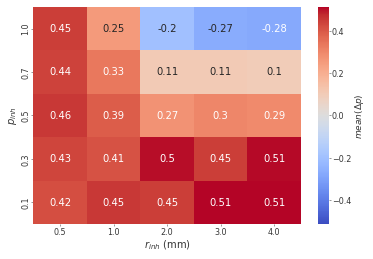

In [10]:
def plot_means(ax):
    mean_over_nets_and_run = delta_p.groupby(['p_inh', 'r_inh'])['delta_p'].mean()
    vmax = mean_over_nets_and_run.abs().max()
    sns.heatmap(mean_over_nets_and_run.unstack()[::-1], annot=True, cbar_kws={'label': '$mean(\Delta p)$'}, cmap='coolwarm', vmin=-vmax, vmax=vmax, ax=ax)
    ax.set_xlabel('$r_{inh}$ (mm)', fontsize=plt.rcParams['axes.titlesize'])
    ax.set_ylabel('$p_{inh}$', fontsize=plt.rcParams['axes.titlesize'])

fig, ax = plt.subplots()
plot_means(ax)

array([[<Axes: ylabel='1.0'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='0.7'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='0.5'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='0.3'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='0.5', ylabel='0.1'>, <Axes: xlabel='1.0'>,
        <Axes: xlabel='2.0'>, <Axes: xlabel='3.0'>, <Axes: xlabel='4.0'>]],
      dtype=object)

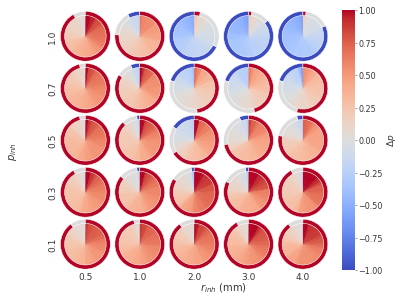

In [11]:
fig = plt.figure(layout='compressed', facecolor='w')

def plot_pies(fig):
    axs = fig.subplots(5,5)
    colormap = plt.get_cmap('coolwarm')

    for p, row in zip(p_list, axs):
        for r, ax in zip(r_list, row):
            data = delta_p[(delta_p.p_inh==p) & (delta_p.r_inh==r)].sort_values(by='delta_p')
            
            # Number of slices
            num_slices = len(data)
            
            # Assign colors to slices based on normalized delta_p values
            colors = [colormap(min(1., max(0., (val+1)/2))) for val in data.delta_p]
            
            # Plot the pie chart with equal-sized slices
            for angle in (88, 90):  # Rotated double underneath to avoid edge artifacts in pdf export
                ax.pie(np.ones(num_slices), startangle=angle, colors=colors, wedgeprops=dict(lw=0))

            # Draw a larger pie underneath with three slices and categorical colors
            category_sizes = [sum(data.delta_p <= -0.1), sum((-0.1 < data.delta_p) & (data.delta_p < 0.1)), sum(data.delta_p >= 0.1)]
            category_colors = [colormap(i) for i in (0., .5, 1.)]
            ax.pie(category_sizes, radius=1.2, startangle=90, colors=category_colors, wedgeprops=dict(width=0.2, edgecolor='w'))

    # Set labels and show the plot
    for ax, p_inh in zip(axs[:, 0], p_list):
        ax.set_ylabel(p_inh)
    for ax, r_inh in zip(axs[-1, :], r_list):
        ax.set_xlabel(r_inh)
    fig.supxlabel('$r_{inh}$ (mm)', fontsize=plt.rcParams['axes.titlesize'])
    fig.supylabel('$p_{inh}$', fontsize=plt.rcParams['axes.titlesize'])

    # Add a colorbar to the right of the plot
    norm = plt.Normalize(vmin=-1, vmax=1)
    cb = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=colormap), ax=axs)
    cb.set_label('$\Delta p$')
    cb.outline.set_color('none')

    fig.get_layout_engine().set(h_pad=0, hspace=0, w_pad=0, wspace=0)
    
    return axs

plot_pies(fig)

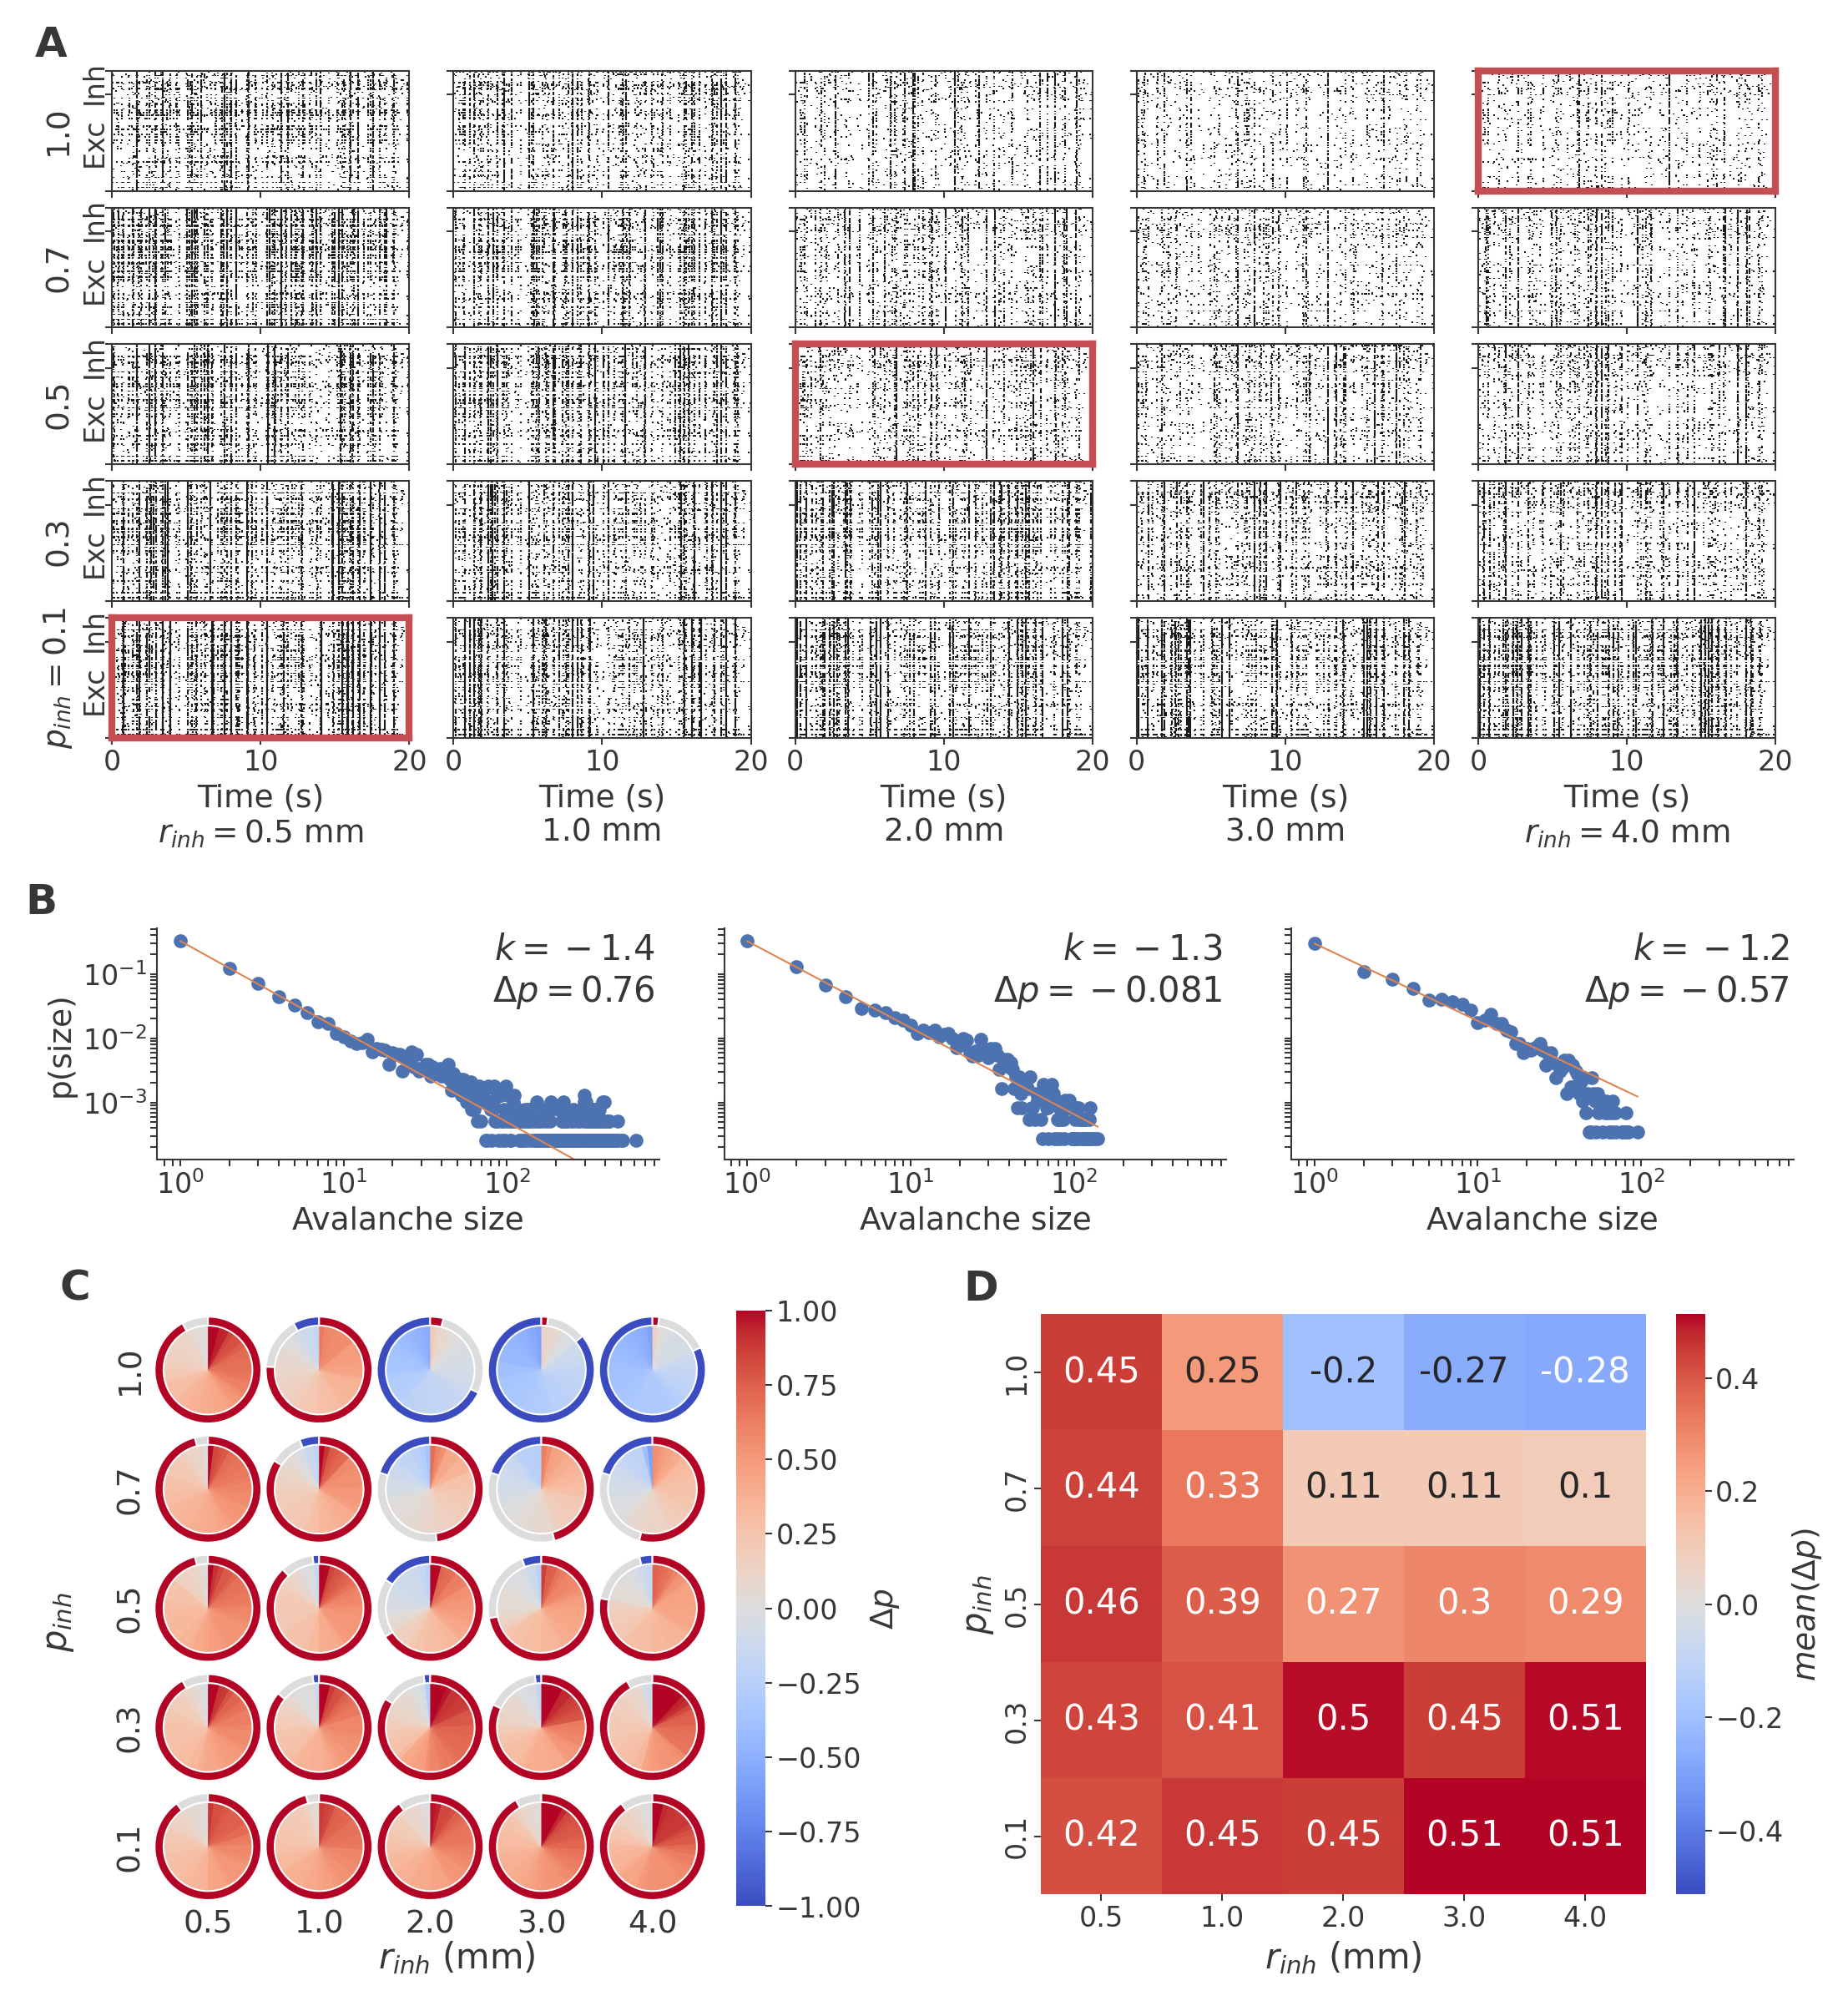

In [12]:
fig = plt.figure(figsize=pu.fullwidth(7), layout='compressed', dpi=300, facecolor='w')
subfigs = fig.subfigures(3, height_ratios=(7,3,6), hspace=.05)

ax_raster = subfigs[0].subplots(5,5, sharex=True, sharey=True, gridspec_kw=dict(wspace=.05))
plot_rasters(ax_raster)
pu.label_panel(ax_raster[0,0], 0)

ax_detail = subfigs[1].subplots(1,3, sharex=True, sharey=True, gridspec_kw=dict(wspace=.1))
min_p = []
for p, r, ax in zip(p_highlights, r_highlights, ax_detail):
    script, path = get_script(f'lif_alpha_beta_1_different_net_seed_0_pinh_{p}_rinh_{r}_runseed_{runseed}')
    min_p.append(plot_detail(path, 15, ax))
for ax in ax_detail[1:]:
    ax.set_ylabel('')
ax.set_ylim(bottom=min(min_p)/2)
pu.label_panel(ax_detail[0], 1)

subfigs = subfigs[2].subfigures(1, 2, wspace=.1)
ax_heatmap = subfigs[1].subplots()
plot_means(ax_heatmap)
pu.label_panel(ax_heatmap, 3)

axs_pies = plot_pies(subfigs[0])
pu.label_panel(axs_pies[0,0], 2, left=2)

plt.savefig('Figure 4.tif', bbox_inches='tight')

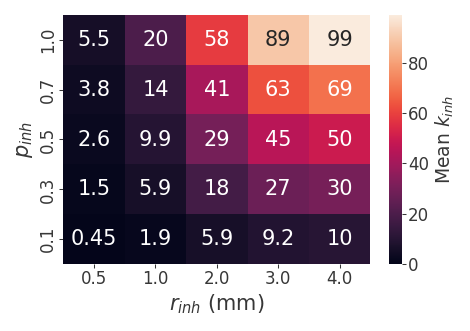

In [13]:
def plot_kmean(ax):
    mean_k = delta_p.groupby(['p_inh', 'r_inh'])['k_inh_init'].mean()
    sns.heatmap(mean_k.unstack()[::-1], annot=True, cbar_kws={'label': 'Mean $k_{inh}$'}, ax=ax, vmin=0)
    ax.set_xlabel('$r_{inh}$ (mm)', fontsize=plt.rcParams['axes.titlesize'])
    ax.set_ylabel('$p_{inh}$', fontsize=plt.rcParams['axes.titlesize'])

fig, ax = plt.subplots(figsize=pu.halfwidth(2), facecolor='w', dpi=150)
plot_kmean(ax)

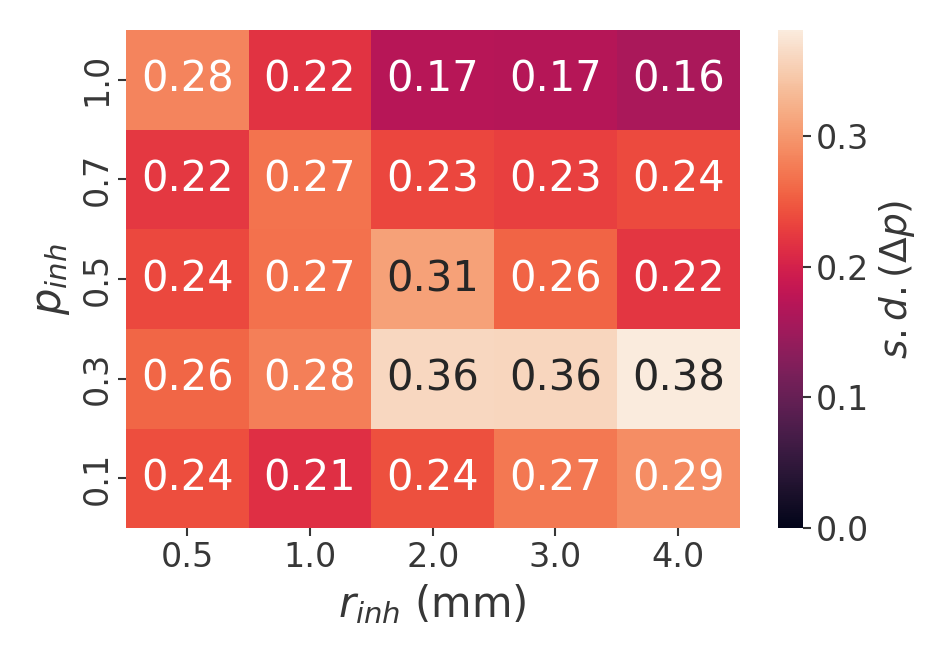

In [14]:
def plot_sds(ax):
    std_over_nets_and_run = delta_p.groupby(['p_inh', 'r_inh'])['delta_p'].std()
    sns.heatmap(std_over_nets_and_run.unstack()[::-1], annot=True, cbar_kws={'label': '$s.d.(\Delta p)$'}, ax=ax, vmin=0)
    ax.set_xlabel('$r_{inh}$ (mm)', fontsize=plt.rcParams['axes.titlesize'])
    ax.set_ylabel('$p_{inh}$', fontsize=plt.rcParams['axes.titlesize'])

fig, ax = plt.subplots(figsize=pu.halfwidth(2), facecolor='w', dpi=300)
plot_sds(ax)
fig.savefig('Figure 4.Suppl1.tif', bbox_inches='tight')